## Script 1, A Nambiar 

#### (Preprocessing)

### Article Clean Up

In [1]:
!pip install pyarrow

In [2]:
import pandas as pd
import pyarrow
import re

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package wordnet to /Users/ankita7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ankita7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankita7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pip install progress

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandarallel

Note: you may need to restart the kernel to use updated packages.


In [5]:
from pandarallel import pandarallel
import multiprocessing
from progress.bar import Bar

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=Bar())

Available CPUs: 10
INFO: Pandarallel will run on 9 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Preprocessing 

#### Load Data

In [6]:
df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')

In [7]:
df_news_final_project.head()

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interc..."
3,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n \nSkip to content\n\nConsumer Electronics Net\n\nPrimary Menu\n\nConsumer Electronics Net\n\nSearch for:\n \nHomeNewsStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered \n \n News\n \n \nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered\n 7 hours...
4,http://www.itbusinessnet.com/2020/10/olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application/?utm_source=rss&utm_medium=rss&utm_campaign=olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net,\n\nOlympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net\n \nSkip to content\n\nIT Business Net\n\nNews for IT Professionals\nPrimary Menu\n\nIT Business Net\nAbout IT Business Net\n\nSearch for:\n \nHome2020OctoberOlympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application \n \n News\n ...


#### Initial Data Analysis

In [8]:
df = df_news_final_project[df_news_final_project['language'] == 'en']
df.shape

(200332, 5)

In [9]:
df.nunique()

url         200332
date          1213
language         1
title       140223
text        198564
dtype: int64

In [10]:
df.shape

(200332, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200332 non-null  object
 1   date      200332 non-null  object
 2   language  200332 non-null  object
 3   title     200332 non-null  object
 4   text      200332 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


#### Drop Duplicates

In [12]:
df = df.drop_duplicates(subset=['title'], keep='first')

In [13]:
df.nunique()

url         140223
date          1213
language         1
title       140223
text        140223
dtype: int64

140,223 articles in sample. 

#### Data Sampling

In [14]:
#df = df.sample(n=1000, random_state=42)

#### Find Average Word, Sentence, and Article Length

In [14]:
text_doc = df['text']
text_doc_word_lengths = text_doc.str.len()
avg_word_len_before = text_doc_word_lengths.mean()

In [17]:
sentences = text_doc.str.split('[.!?]')
sentence_lengths = sentences.apply(len)
avg_sent_len_before = sentence_lengths.mean()

In [18]:
# Compute the mean article length
word_counts = text_doc.apply(lambda x: len(x.split()))
article_lengths = word_counts.sum()
article_len_before = article_lengths / len(text_doc)

In [19]:
print(f"Average word length: {avg_word_len_before} characters")
print(f"Average sentence length: {avg_sent_len_before} words")
print(f"Average article length: {article_len_before} words")

Average word length: 9664.156850160101 characters
Average sentence length: 61.27847072163625 words
Average article length: 1327.7224278470721 words


Average word length: 9664.156850160101 characters

Average sentence length: 61.27847072163625 words

Average article length: 1327.7224278470721 words

#### Word Cloud

In [15]:
from wordcloud import WordCloud

In [16]:
initial_texts = df['text']

In [17]:
import matplotlib.pyplot as plt

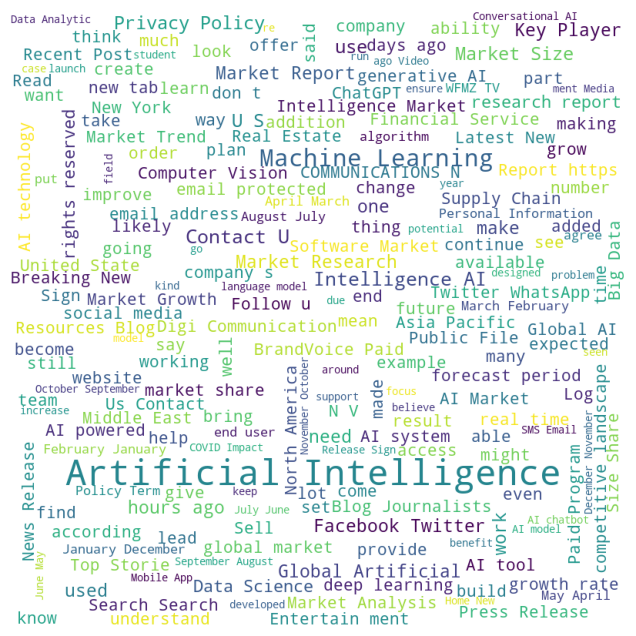

In [18]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(initial_texts))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Text Frequency Over Time

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

texts_per_month = df.resample('M').count()

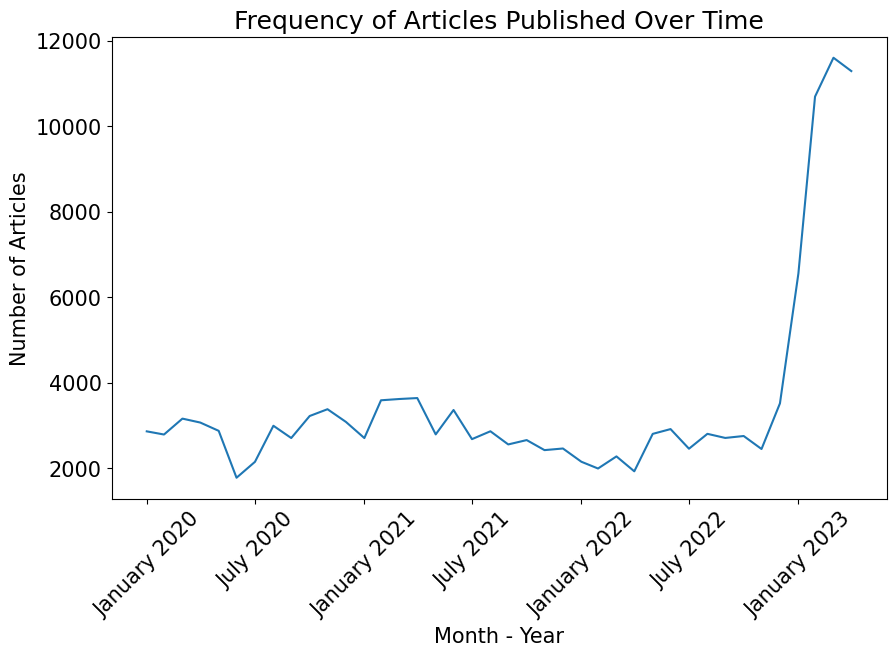

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(texts_per_month.index, texts_per_month['text'])
plt.title('Frequency of Articles Published Over Time')
plt.rcParams.update({'font.size': 15})

tick_locations = texts_per_month.index[::6]
tick_labels = [date.strftime('%B %Y') for date in tick_locations]
plt.xticks(tick_locations, tick_labels)

plt.xlabel('Month - Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

#### Clean Text

##### Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [22]:
def newline_tab(text):
    # Replace newline characters with spaces
    text = re.sub(r'\n', ' ', text)
    # Replace tab characters with spaces
    text = re.sub(r'\t', ' ', text)
    return text

In [23]:
#def article_phrase(text, phrases, max_words_after_phrase=60):
#    for phrase in phrases:
#        pattern = re.compile(r'(' + re.escape(phrase) + r')\W.*', re.IGNORECASE | re.DOTALL)
 #       match = re.search(pattern, text)
        
  #      if match:
   #         pos = match.start(1)
    #        words_after_phrase = len(re.findall(r'\w+', text[pos:]))
            
     #       if words_after_phrase <= max_words_after_phrase:
      #          text = text[:pos].strip()
    #return text

In [24]:
common_phrases = [
    "Skip to content",
    "Skip to main content",
    "Related Articles",
    "Related Stories",
    "Advertisement",
    "Sponsored Content",
    "Share this",
    "Share on",
    "Comments",
    "Leave a Reply",
    "Subscribe",
    "Sign up",
    "About the Author",
    "Author Bio",
    "Copyright",
    "All rights reserved",
    "Source",
    "Originally published on",
    "The above press release",
    "READ MORE",
    "Read more",
    "Contact Us",
    "Read More",
    "Copyright",
    "To see more",
    "For additional information",
    "For more information"
]

In [25]:
def article_phrase(_text, endings, position_ratio=0.75):
    for ending in endings:
        pattern = re.compile(r'(' + re.escape(ending) + r')\W.*', re.IGNORECASE | re.DOTALL)
        match = re.search(pattern, _text)
        
        if match:
            pos = match.start(1)
            
            if pos >= len(_text) * position_ratio:
                _text = _text[:pos].strip()  # Remove the ending and everything after it
            else:
                _text = _text[:pos] + _text[pos+len(ending):]  # Remove only the ending
    return _text

In [26]:
def noisy_lines(text):
    for phrase in common_phrases:
        text = re.sub(phrase, ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [27]:
def remove_words_sentences_by_length(text, max_word_length=25, min_sentence_length=5, max_sentence_length=45):
    # Filter by word length (did not remove small ones, want to keep acronyms like AI and IT)
    filtered_words = [word for word in text.split() if len(word) <= max_word_length]
    text = ' '.join(filtered_words)

    sentences = sent_tokenize(text)
    filtered_sentences = [s for s in sentences if min_sentence_length <= len(s.split()) <= max_sentence_length]

    return ' '.join(filtered_sentences)

In [28]:
def remove_unncessary(text):
    # Remove special characters and stopwords
    words = [re.sub(r'[^\w\s]', '', word) for word in text.split() if word.lower() not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text.strip()

In [29]:
df['cleaned_text'] = df['text'].apply(newline_tab)

In [30]:
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda t: article_phrase(t, endings=common_phrases, position_ratio=0.75))

In [31]:
df['cleaned_text'] = df['cleaned_text'].apply(noisy_lines)

In [32]:
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda t: remove_words_sentences_by_length(t, max_word_length=25, 
                                               min_sentence_length=5, max_sentence_length=45))

In [33]:
df['important_words'] = df['cleaned_text'].apply(remove_unncessary)

In [34]:
df.head()

,url,date,language,title,text,cleaned_text,important_words
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they dri...",urban areas city started use ETC system roadside parking spaces since July 1 2019 city deepens roadside parking reform ETC system almost covered roadside parking spaces city proportion vehicles parked roads using system exceeding 90 percent AIempowered system drivers park vehicles parking spots roadside pay parking charge via mobile phones drive away This road used full cars even normal lanes occupied could hardly move bit morning evening commute time recalled citizen surnamed Wang lives Cha...
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve it tweak trouble ranges problem kid...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\

#### Lemmatizer

In [35]:
lemmatizer = WordNetLemmatizer()

In [36]:
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [37]:
#df['important_words'] = df['important_words'].apply(lemmatize_text)
df['important_words'] = df['important_words'].apply(remove_unncessary)

##### LATER: 
##### - Discard irrelevant articles by Loooking at Topics
##### - N-grams: consider for topic modeling

In [38]:
df.to_parquet('preprocessed_news_final_1.parquet')

In [39]:
df.shape

(140223, 7)

In [40]:
df.head(15)

,url,date,language,title,text,cleaned_text,important_words
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they dri...",urban areas city started use ETC system roadside parking spaces since July 1 2019 city deepens roadside parking reform ETC system almost covered roadside parking spaces city proportion vehicles parked roads using system exceeding 90 percent AIempowered system drivers park vehicles parking spots roadside pay parking charge via mobile phones drive away road used full cars even normal lanes occupied could hardly move bit morning evening commute time recalled citizen surnamed Wang lives Chaoyang...
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve tweak trouble ranges problem kid cor...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection

In [36]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /home/jupyter


## 2. Initial Exploratory Data Analysis

In [39]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 6.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
import seaborn as sns

#### Average

In [45]:
# Calculate average word length for important words
important_words = df['important_words']
important_word_lengths = important_words.str.len()
avg_word_len_after_imp = important_word_lengths.mean()

In [46]:
# Calculate average word length for all words
cleaned_text = df['cleaned_text']
cleaned_word_lengths = cleaned_text.str.len()
avg_word_len_after = cleaned_word_lengths.mean()

In [47]:
# Calculate average sentence length
sentences = cleaned_text.str.split('[.!?]')
sentence_lengths = sentences.apply(len)
avg_sent_len_after = sentence_lengths.mean()

In [50]:
# Compute the mean article length
word_counts = cleaned_text.apply(lambda x: len(x.split()))
article_lengths = word_counts.sum()
article_len_after = article_lengths / len(cleaned_text)

In [51]:
print(f"Average word length for more important words: {avg_word_len_after_imp} characters")
print(f"Average word length for all words: {avg_word_len_after} characters")
print(f"Average sentence length: {avg_sent_len_after} words")
print(f"Average article length: {article_len_after} words")

Average word length for more important words: 2582.5973057201745 characters
Average word length for all words: 3452.27824251371 characters
Average sentence length: 31.69750326266019 words
Average article length: 539.7203311867526 words


#### Word Cloud

In [60]:
cleaned_texts = df['important_words']

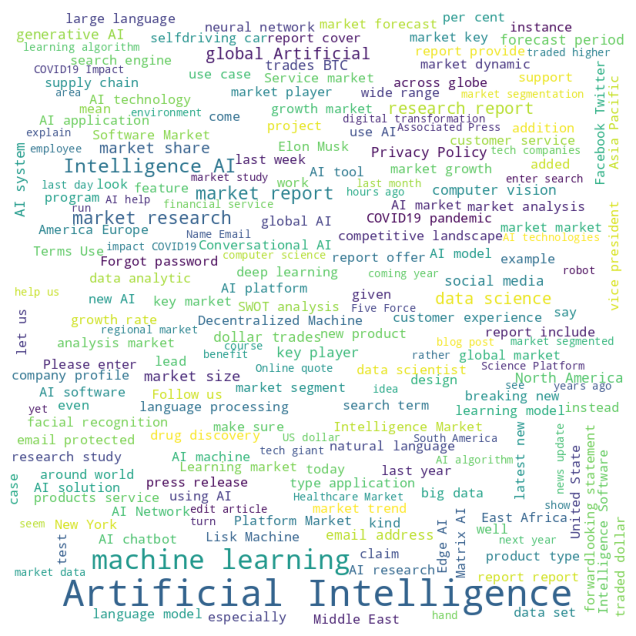

In [61]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cleaned_texts))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()